# Saliency, Vanishing Point, Depth 

This notebook focuses on analyzing and visualizing the relationship between saliency and depth in various scenes. The objective is to explore whether participants' gaze is drawn to specific regions that may be influenced by the depth of the scene. Additionally, vanishing point estimation is used to provide further insights into participants' visual attention and the overall structural organization of the scene.

In [3]:
%load_ext autoreload
%autoreload 2

In [23]:
import sys

sys.path.append("../")

import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from justpfm import justpfm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

from src.utils.file import (
    get_files_recursive, 
    get_ids_from_file_path, 
    get_set_str,
)
from src.config import (
    DEPTH_MAP_PFM_PATH, 
    SALIENCY_MAP_PFM_PATH, 
    VANISHING_POINT_MAP_PFM_PATH, 
    SALIENCY_VANISHING_POINT_DEPTH_VIZ_PATH,
)

N_BINS = 100
KDE_SIZE = 100
KDE_BANDWIDTH = 10
MAX_DEPTH_VALUE = 5

In [24]:
if not os.path.exists(DEPTH_MAP_PFM_PATH):
    print(f"❌ {Path(DEPTH_MAP_PFM_PATH).resolve()} does not exist. Please run the DEPTH computation script first.")
elif not os.path.exists(SALIENCY_MAP_PFM_PATH):
    print(f"❌ {Path(SALIENCY_MAP_PFM_PATH).resolve()} does not exist. Please run the SALIENCY computation script first.")
elif not os.path.exists(VANISHING_POINT_MAP_PFM_PATH):
    print(f"❌ {Path(VANISHING_POINT_MAP_PFM_PATH).resolve()} does not exist. Please run the VANISHING POINT computation script first.")
else:
    print(f"✅ You are good to go!")

✅ You are good to go!


## Single Sequence Visualization

In [25]:
def load_map(file_path: str, max_value: int | None = None):
    """
    Load a depth map from a pfm file.

    Args:
        file_path (str): The path to the pfm file.
        max_value (int | None): The maximum value to normalize the map. Defaults to None.

    Returns:
        np.ndarray: The depth map.
    """
    map = justpfm.read_pfm(file_path)
    map = np.squeeze(map).astype(np.float32)

    if max_value is not None:
        map = np.clip(map, 0, max_value)

    cv2.normalize(map, map, 0, 1, cv2.NORM_MINMAX)

    return map

def plot_saliency_vanishing_point_depth_visualization(
    experiment_id: int, set_id: int, sequence_id: int, with_vanishing_map: bool
) -> None:
    """
    Plot saliency, vanishing point and depth maps for a given experiment, set and sequence.

    Args:
        experiment_id (int): The experiment id.
        set_id (int): The set id.
        sequence_id (int): The sequence id.
        with_vanishing_map (bool): Whether to show the vanishing point map.
    """
    # Load saliency and depth maps
    set_str = get_set_str(experiment_id=experiment_id, set_id=set_id)
    depth_file_path = f"{DEPTH_MAP_PFM_PATH}/experiment{experiment_id}/{set_str}/scene{sequence_id:02}.pfm"
    saliency_file_path = f"{SALIENCY_MAP_PFM_PATH}/experiment{experiment_id}/{set_str}/scene{sequence_id:02}.pfm"
    depth_map = load_map(file_path=depth_file_path, max_value=MAX_DEPTH_VALUE)
    saliency_map = load_map(file_path=saliency_file_path)


    # Load vanishing point map if needed
    if with_vanishing_map:
        image_file_path = f"{VANISHING_POINT_MAP_PFM_PATH}/experiment{experiment_id}/{set_str}/scene{sequence_id:02}.pfm"
        vanishing_point_map = load_map(file_path=image_file_path)

    # Show maps on top of each other
    plt.figure(figsize=(15, 3))
    plt.imshow(depth_map, cmap="gray")
    plt.colorbar(label="Depth")
    if with_vanishing_map:
        plt.imshow(vanishing_point_map, cmap="magma", alpha=0.25)
        plt.colorbar(label="Vanishing point")
    contours = plt.contour(saliency_map, levels=10, cmap="jet", alpha=0.25)
    plt.colorbar(contours, label="Saliency")
    plt.title(
        f"Depth map and saliency map for Experiment {experiment_id} Set {set_id} Sequence {sequence_id}"
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

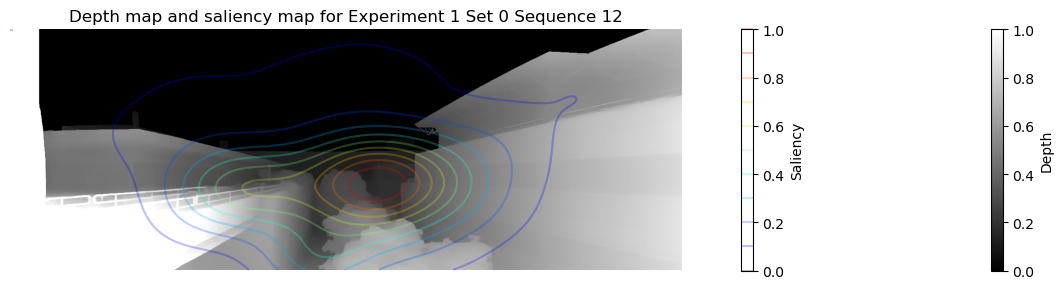

In [26]:
plot_saliency_vanishing_point_depth_visualization(experiment_id=1, set_id=0, sequence_id=12, with_vanishing_map=False)

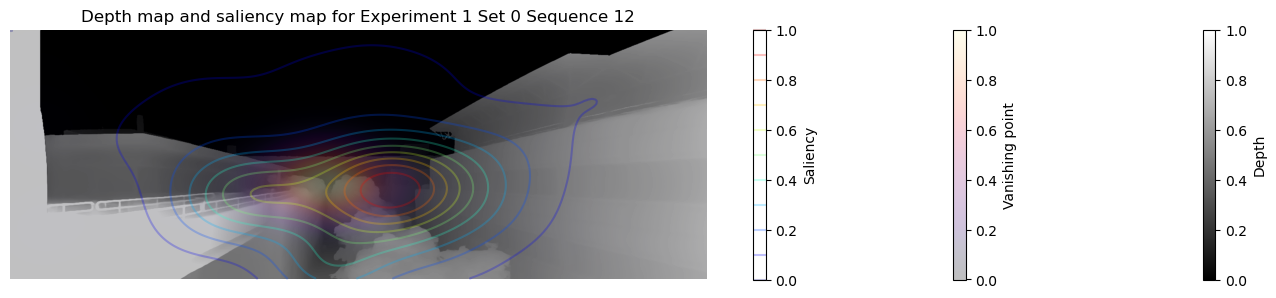

In [27]:
plot_saliency_vanishing_point_depth_visualization(experiment_id=1, set_id=0, sequence_id=12, with_vanishing_map=True)

## Saving All Sequence Visualizations

In [28]:
def save_saliency_vanishing_point_depth_visualizations() -> None:
    """
    Save saliency, vanishing point and depth maps for all experiments, sets and sequences.
    """
    saliency_file_paths = get_files_recursive(SALIENCY_MAP_PFM_PATH, "*.pfm")
    saliency_file_paths = sorted(saliency_file_paths)
    vanishing_point_file_paths = get_files_recursive(VANISHING_POINT_MAP_PFM_PATH, "*.pfm")
    vanishing_point_file_paths = sorted(vanishing_point_file_paths)
    depth_file_paths = get_files_recursive(DEPTH_MAP_PFM_PATH, "*.pfm")
    depth_file_paths = sorted(depth_file_paths)

    for saliency_file_path, vanishing_point_file_path, depth_file_path in tqdm(zip(saliency_file_paths, vanishing_point_file_paths, depth_file_paths), desc="⌛ Saving visualizations..."):
        # Get maps and normalize them
        saliency_map = load_map(saliency_file_path)
        vanishing_point_map = load_map(vanishing_point_file_path)
        depth_map = load_map(depth_file_path, max_value=MAX_DEPTH_VALUE)

        # Get visualization file path
        experiment_id, set_id, sequence_id = get_ids_from_file_path(file_path=saliency_file_path)
        set_str = get_set_str(experiment_id=experiment_id, set_id=set_id)
        visualization_file_path = f"{SALIENCY_VANISHING_POINT_DEPTH_VIZ_PATH}/experiment{experiment_id}/{set_str}/scene{sequence_id:02}.png"

        # Plot and save depth visualization
        os.makedirs(os.path.dirname(visualization_file_path), exist_ok=True)
        plt.figure(figsize=(15, 3))
        plt.imshow(depth_map, cmap="gray")
        plt.colorbar(label="Depth")
        plt.imshow(vanishing_point_map, cmap="magma", alpha=0.25)
        plt.colorbar(label="Vanishing point")
        contours = plt.contour(saliency_map, levels=10, cmap="jet", alpha=0.25)
        plt.colorbar(contours, label="Saliency")
        plt.title(f"Depth map and saliency map for Experiment {experiment_id} Set {set_id} Sequence {sequence_id:02}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(visualization_file_path)
        plt.close()

    print(f"✅ Visualizations saved to {Path(SALIENCY_VANISHING_POINT_DEPTH_VIZ_PATH).resolve()}")


In [29]:
save_saliency_vanishing_point_depth_visualizations()

⌛ Saving visualizations...: 50it [00:27,  1.82it/s]

✅ Visualizations saved to C:\Users\arnau\cours\master_project\git\generated\saliency_vanishing_point_depth\viz


## Saliency and Depth 2D Histogram

### 2D Histogram

In [27]:
def get_saliency_depth_features() -> np.ndarray:
    """
    Load all depth and saliency maps and return them as a 2D array

    Returns:
        np.ndarray: 2D array of depth and saliency maps
    """
    depth_file_paths = Path(DEPTH_MAP_PFM_PATH).rglob("*.pfm")
    depth_file_paths = sorted(depth_file_paths)
    saliency_file_paths = Path(SALIENCY_MAP_PFM_PATH).rglob("*.pfm")
    saliency_file_paths = sorted(saliency_file_paths)

    X = []
    for depth_file_path, saliency_file_path in tqdm(
        zip(depth_file_paths, saliency_file_paths), desc="⌛ Loading maps..."
    ):
        # Load maps
        depth_map = justpfm.read_pfm(depth_file_path)
        saliency_map = justpfm.read_pfm(saliency_file_path)

        # Normalize maps
        depth_map = cv2.normalize(depth_map, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        depth_map = 1 - depth_map
        saliency_map = cv2.normalize(saliency_map, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        saliency_map = cv2.resize(
            saliency_map, (depth_map.shape[1], depth_map.shape[0])
        )

        # Merge the maps
        maps = np.dstack((depth_map, saliency_map))
        flat_maps = maps.reshape(-1, 2)

        # Append to the dataset
        X = np.vstack((X, flat_maps)) if len(X) else flat_maps

    return X

In [28]:
X_saliency = get_saliency_depth_features()

⌛ Loading maps...: 50it [00:05,  8.72it/s]


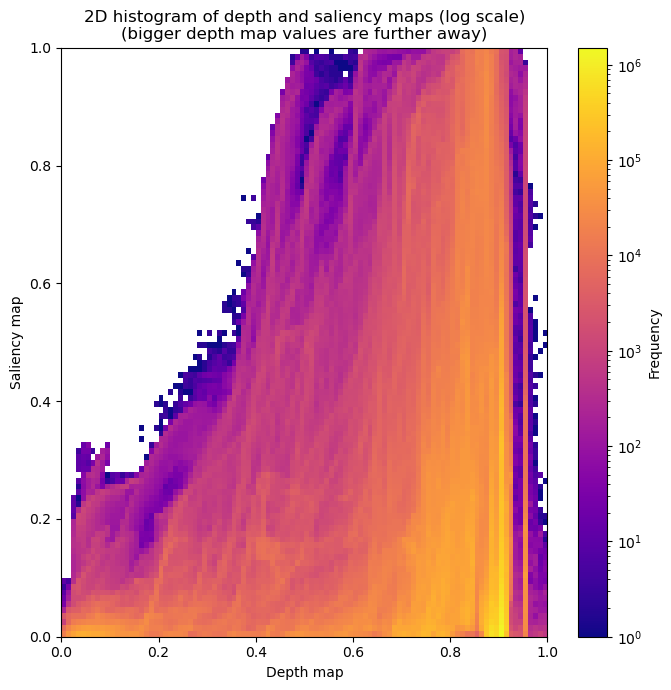

In [38]:
# Plot 2D histogram of depth and saliency maps
plt.figure(figsize=(7, 7))
plt.hist2d(X_saliency[:, 0], X_saliency[:, 1], bins=N_BINS, cmap="plasma", norm=mcolors.LogNorm())
plt.xlabel("Depth map")
plt.ylabel("Saliency map")
plt.title(
    "2D histogram of depth and saliency maps (log scale)\n(bigger depth values are further away)"
)
plt.tight_layout()
plt.colorbar(label="Frequency")
plt.show()

### Normalized 2D Histogram

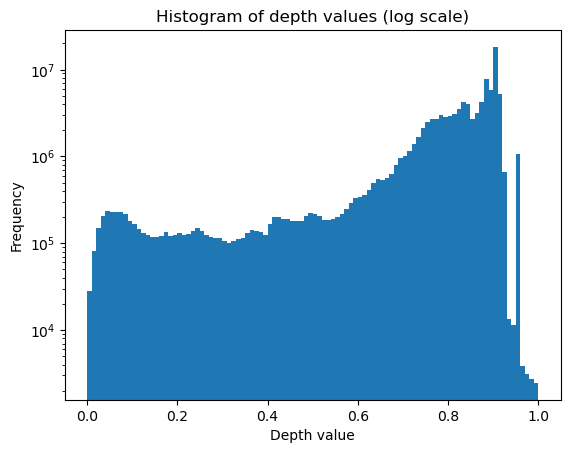

In [30]:
# Plot histogram of depth values
depth_values = X_saliency[:, 0]
plt.hist(depth_values, bins=N_BINS)
plt.title("Histogram of depth values (log scale)")
plt.xlabel("Depth value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

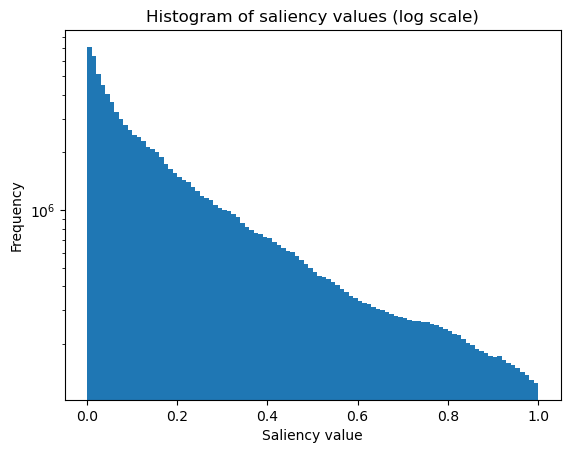

In [31]:
saliency_values = X_saliency[:, 1]
plt.hist(saliency_values, bins=N_BINS)
plt.title("Histogram of saliency values (log scale)")
plt.xlabel("Saliency value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [39]:
def get_normalized_2d_histogram(
    X: np.ndarray, eps: float = 1e-8
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the normalized 2D histogram of depth and saliency maps.

    Args:
        X (np.ndarray): The 2D array of depth and saliency maps.
        eps (float, optional): The epsilon value for numerical stability. Defaults to 1e-8.

    Returns:
        np.ndarray: The 2D histogram.
        np.ndarray: The x-axis bin edges.
        np.ndarray: The y-axis bin edges.
    """
    # Compute the 1D histogram of depth values
    depth_values = X[:, 0]
    depth_hist, _ = np.histogram(depth_values, bins=N_BINS)

    # Compute the 1D histogram of saliency values
    saliency_values = X[:, 1]
    saliency_hist, __package__ = np.histogram(saliency_values, bins=N_BINS)

    # Compute the 2D histogram of depth and saliency
    saliency_values = X[:, 1]
    hist_2d, xedges, yedges = np.histogram2d(depth_values, saliency_values, bins=N_BINS)

    # Normalize the 2D histogram by the 1D histograms
    depth_hist_adjusted = depth_hist + eps
    saliency_hist_adjusted = saliency_hist + eps
    normalization_matrix = np.outer(depth_hist_adjusted, saliency_hist_adjusted)
    normalized_hist_2d = hist_2d / normalization_matrix

    # Normalize to have a sum of 1
    normalized_hist_2d = normalized_hist_2d / np.sum(normalized_hist_2d)

    return normalized_hist_2d, xedges, yedges


def plot_normalized_2d_histogram(
    normalized_hist_2d: np.ndarray, xedges: np.ndarray, yedges: np.ndarray
) -> None:
    """
    Plot the normalized 2D histogram of depth and saliency maps.

    Args:
        normalized_hist_2d (np.ndarray): The normalized 2D histogram.
        xedges (np.ndarray): The x-axis bin edges.
        yedges (np.ndarray): The y-axis bin edges.
    """
    plt.figure(figsize=(7, 7))
    plt.imshow(
        normalized_hist_2d.T,
        origin="lower",
        aspect="auto",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        cmap="plasma",
        norm=mcolors.LogNorm(),
    )
    plt.colorbar(label="Normalized frequency")
    plt.xlabel("Depth map")
    plt.ylabel("Saliency map")
    plt.title(
        "Normalized 2D histogram of depth and saliency maps (log scale)\n(bigger depth values are further away)"
    )
    plt.tight_layout()
    plt.show()

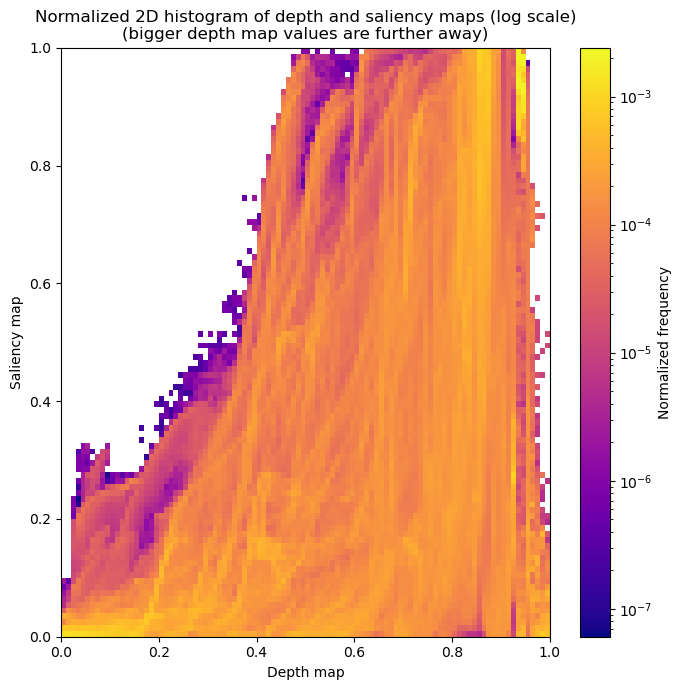

In [40]:
# Plot the 2D normalized histogram of depth and saliency maps
normalized_hist_2d, xedges, yedges = get_normalized_2d_histogram(X_saliency)
plot_normalized_2d_histogram(normalized_hist_2d, xedges, yedges)

### Center Bias

In [35]:
def get_global_saliency_map() -> np.ndarray:
    """
    Get the global saliency map by merging all saliency maps

    Returns:
        np.ndarray: global saliency map
    """
    saliency_file_paths = Path(SALIENCY_MAP_PFM_PATH).rglob("*.pfm")
    saliency_file_paths = sorted(saliency_file_paths)

    global_saliency_map = None
    for saliency_file_path in tqdm(
        saliency_file_paths, desc="⌛ Loading saliency maps..."
    ):
        # Load map and merge
        saliency_map = justpfm.read_pfm(saliency_file_path)
        if global_saliency_map is None:
            global_saliency_map = saliency_map
        else:
            global_saliency_map += saliency_map

    # To unit distribution
    global_saliency_map /= global_saliency_map.sum()
    global_saliency_map = np.squeeze(global_saliency_map)

    return global_saliency_map


def gaussian_2d(
    x: np.ndarray,
    y: np.ndarray,
    x0: float,
    y0: float,
    sigma_x: float,
    sigma_y: float,
    A: float,
) -> np.ndarray:
    """
    A 2D Gaussian function

    Args:
        x (np.ndarray): x values
        y (np.ndarray): y values
        x0 (float): x center
        y0 (float): y center
        sigma_x (float): x standard deviation
        sigma_y (float): y standard deviation
        A (float): amplitude
    """

    return A * np.exp(
        -((x - x0) ** 2 / (2 * sigma_x**2) + (y - y0) ** 2 / (2 * sigma_y**2))
    )


def fit_gaussian(
    data: np.ndarray,
    width: int,
    height: int,
) -> np.ndarray:
    """
    Fit a 2D Gaussian to the given data

    Args:
        data (np.ndarray): 2D data to fit
        width (int): width of the data
        height (int): height of the data

    Returns:
        np.ndarray: fitted Gaussian
    """
    # Create a 2D grid
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the arrays to fit with curve_fit
    x_data = np.vstack((x.ravel(), y.ravel()))
    z_data = data.ravel()

    # Start with an initial guess for (x0, y0, sigma_x, sigma_y, A)
    initial_guess = (width // 2, height // 2, 20, 30, 1)

    # Fit the Gaussian model to the data
    popt, _ = curve_fit(
        lambda xdata, x0, y0, sigma_x, sigma_y, A: gaussian_2d(
            xdata[0], xdata[1], x0, y0, sigma_x, sigma_y, A
        ),
        x_data,
        z_data,
        p0=initial_guess,
    )

    # Get the optimized parameters
    x0, y0, sigma_x, sigma_y, A = popt
    print(
        f"Optimized parameters: x0={x0}, y0={y0}, sigma_x={sigma_x}, sigma_y={sigma_y}, A={A}"
    )

    # Generate the fitted Gaussian using the optimized parameters
    fitted_gaussian = gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, A)

    return fitted_gaussian


def get_center_bias_depth_features(center_bias_distribution: np.ndarray) -> np.ndarray:
    """
    Load all depth maps and return them as a 2D array with the center bias distribution

    Args:
        center_bias_distribution (np.ndarray): center bias distribution

    Returns:
        np.ndarray: 2D array of depth maps with center bias distribution
    """
    depth_file_paths = Path(DEPTH_MAP_PFM_PATH).rglob("*.pfm")
    depth_file_paths = sorted(depth_file_paths)

    X = []
    for depth_file_path in tqdm(depth_file_paths, desc="⌛ Loading maps..."):
        # Load maps
        depth_map = justpfm.read_pfm(depth_file_path)
        saliency_map = center_bias_distribution.copy()

        # Normalize the depth map
        depth_map = cv2.normalize(depth_map, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        # Invert the depth map as lower values are initially further away
        depth_map = 1 - depth_map

        # Resize the saliency map to the size of the depth map
        saliency_map = cv2.resize(
            saliency_map, (depth_map.shape[1], depth_map.shape[0])
        )

        # Merge the maps
        maps = np.dstack((depth_map, saliency_map))
        flat_maps = maps.reshape(-1, 2)

        # Append to the dataset
        X = np.vstack((X, flat_maps)) if len(X) else flat_maps

    return X

⌛ Loading saliency maps...: 100%|██████████| 50/50 [00:00<00:00, 282.14it/s]


Optimized parameters: x0=1181.2819674543296, y0=570.0310472376283, sigma_x=-538.6871815696735, sigma_y=-207.83431895729927, A=1.5427526438235076e-06


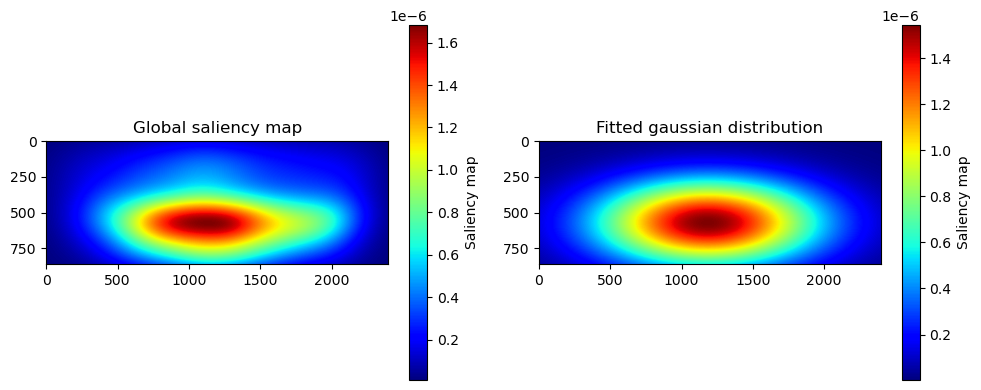

In [36]:
global_saliency_map = get_global_saliency_map()
fitted_gaussian = fit_gaussian(
    data=global_saliency_map,
    width=global_saliency_map.shape[1],
    height=global_saliency_map.shape[0],
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(global_saliency_map, cmap="jet")
plt.colorbar(label="Saliency map")
plt.title("Global saliency map")
plt.subplot(1, 2, 2)
plt.imshow(fitted_gaussian, cmap="jet")
plt.colorbar(label="Saliency map")
plt.title("Fitted gaussian distribution")
plt.tight_layout()
plt.show()

⌛ Loading maps...: 100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


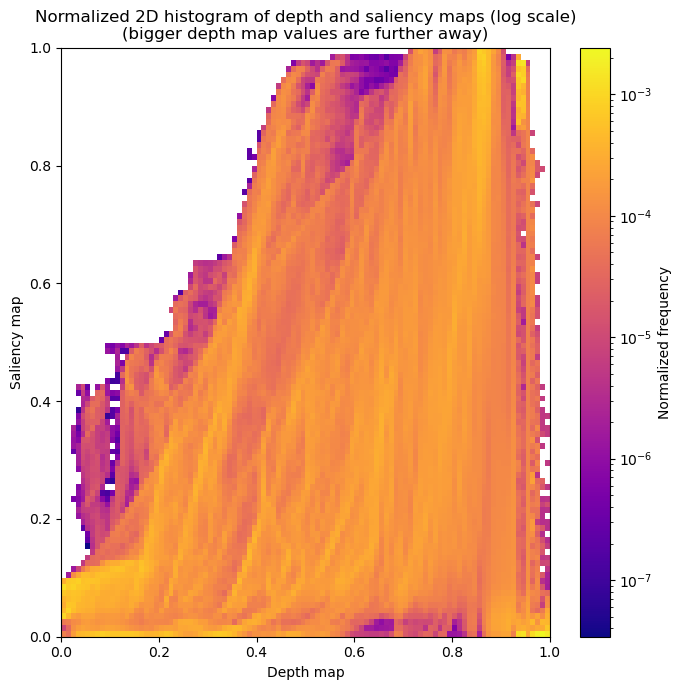

In [41]:
depth_file_paths = Path(DEPTH_MAP_PFM_PATH).rglob("*.pfm")
depth_file_paths = sorted(depth_file_paths)

center_bias_distribution = cv2.normalize(
    fitted_gaussian, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F
)

X_center_bias = get_center_bias_depth_features(center_bias_distribution=center_bias_distribution)

# Plot the 2D normalized histogram of depth and saliency maps
normalized_hist_2d, xedges, yedges = get_normalized_2d_histogram(X_center_bias)
plot_normalized_2d_histogram(normalized_hist_2d, xedges, yedges)